# Causal Models - Assumptions & Challenges

### Loading Libraries

In [6]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# IterTools
from itertools import combinations

# Statistical Models
from scipy import stats
import statsmodels.api as sm

# Networkx
import networkx as nx

# Data Visualization
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV

# DoWhy Causal Libraries
import dowhy
from dowhy import gcm
from dowhy import CausalModel
from dowhy.causal_model import CausalModel

# Notebook Iteration 
from tqdm import tqdm

In [2]:
dowhy.__version__

'0.11.1'

In [30]:
COLORS = [
    '#069AF3',
    '#F97306'
]

## Not Enough Data - The Experiment

### Graph

In [4]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['S', 'Q', 'X', 'Y', 'P']
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

### Experiment

In [7]:
# Define the true effect
TRUE_EFFECT = .7

# Define experiment params
sample_sizes = [30, 100, 1000, 10000]
noise_coefs = [.1, .2, .3, .4, .5, .6, .7, .8]
n_samples = 20

# Record the results
results = []

# Run the experiment
for sample_size in tqdm(sample_sizes):
    for noise_coef in noise_coefs:
        for i in range(n_samples):
        
            # Generate the data
            S = np.random.random(sample_size)
            Q = 0.2*S + noise_coef*np.random.random(sample_size)
            X = 0.14*Q + noise_coef*np.random.random(sample_size)
            Y = TRUE_EFFECT*X + 0.11*Q + 0.32*S + noise_coef*np.random.random(sample_size)
            P = 0.43*X + 0.21*Y + noise_coef*np.random.random(sample_size)

            # Encode as a pandas df
            df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

            # Instantiate the CausalModel 
            model = CausalModel(
                data=df,
                treatment='X',
                outcome='Y',
                graph=gml_string
            )

            # Get the estimand
            estimand = model.identify_effect()

            # Get estimate (DML)
            estimate_dml = model.estimate_effect(
                identified_estimand=estimand,
                method_name='backdoor.econml.dml.DML',
                method_params={
                    'init_params': {
                        'model_y': GradientBoostingRegressor(),
                        'model_t': GradientBoostingRegressor(),
                        'model_final': LassoCV(fit_intercept=False),
                    },
                    'fit_params': {}}
            )   

            # Get estimate (Linear Regression)
            estimate_lr = model.estimate_effect(
                identified_estimand=estimand,
                method_name='backdoor.linear_regression')

            results.append(
                {
                    'sample_size': sample_size,
                    'noise_coef': noise_coef,
                    'estimate_dml': estimate_dml.value,
                    'estimate_lr': estimate_lr.value,
                    'error_dml': estimate_dml.value - TRUE_EFFECT,
                    'error_lr': estimate_lr.value - TRUE_EFFECT
                }
            )

  0%|                                                     | 0/4 [00:00<?, ?it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To ac

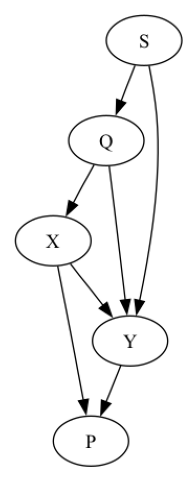

In [8]:
model.view_model()

In [9]:
results_df = pd.DataFrame(results)

In [10]:
results_df

,sample_size,noise_coef,estimate_dml,estimate_lr,error_dml,error_lr
0,30,0.1,0.000000,0.297313,-0.700000,-0.402687
1,30,0.1,0.807393,0.753385,0.107393,0.053385
2,30,0.1,1.402692,1.204324,0.702692,0.504324
3,30,0.1,0.566371,0.512914,-0.133629,-0.187086
4,30,0.1,0.866350,0.601336,0.166350,-0.098664
...,...,...,...,...,...,...
635,10000,0.8,0.705924,0.712182,0.005924,0.012182
636,10000,0.8,0.686752,0.689108,-0.013248,-0.010892
637,10000,0.8,0.706892,0.713372,0.006892,0.013372
638,10000,0.8,0.698701,0.700171,-0.001299,0.000171


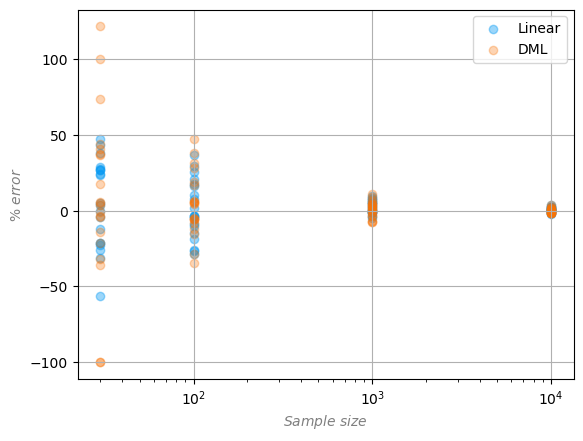

In [31]:
plt.scatter(
    results_df[results_df['noise_coef'] == .3]['sample_size'],
    (results_df[results_df['noise_coef'] == .3]['error_lr'] / TRUE_EFFECT) * 100,
    color=COLORS[0],
    alpha=.4,
    label='Linear'
)

plt.scatter(
    results_df[results_df['noise_coef'] == .3]['sample_size'],
    (results_df[results_df['noise_coef'] == .3]['error_dml'] / TRUE_EFFECT) * 100,
    color=COLORS[1],
    alpha=.3,
    label='DML'
)

plt.xscale('log')
plt.legend()
plt.xlabel('$Sample$ $size$', alpha=.5)
plt.ylabel('% $error$', alpha=.5)
plt.grid(True)
plt.show()

### Positivity Assumption - An Example

In [32]:
# Helpers
def get_y(z, t):
    return z + .2 * z**2 + 10*np.sin(z) + 9*t

#### Bad Case

In [33]:
# Set X values
z_t0 = np.random.uniform(2, 5, 30)
z_t1 = np.random.uniform(5.2, 9, 30)

In [34]:
# Compute Y
y_t0 = get_y(z_t0, 0)
y_t1 = get_y(z_t1, 1)

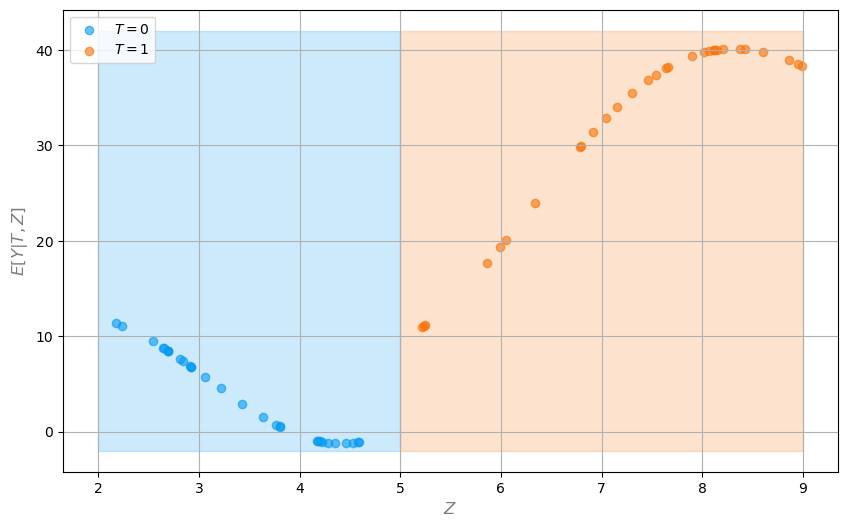

In [35]:
plt.figure(figsize=(10, 6))

plt.fill_betweenx([-2, 42], 5, 9, color=COLORS[1], alpha=.2)
plt.fill_betweenx([-2, 42], 2, 5, color=COLORS[0], alpha=.2)

plt.scatter(z_t0, y_t0, color=COLORS[0], label='$T=0$', alpha=.6)
plt.scatter(z_t1, y_t1, color=COLORS[1], label='$T=1$', alpha=.6)

plt.xlabel('$Z$', alpha=.5, fontsize=12)
plt.ylabel('$E[Y|T, Z]$', alpha=.5, fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

#### Good Case

In [36]:
# Set X values
z_t0 = np.random.uniform(2, 9, 30)
z_t1 = np.random.uniform(2, 9, 30)

# Compute Y
y_t0 = get_y(z_t0, 0)
y_t1 = get_y(z_t1, 1)

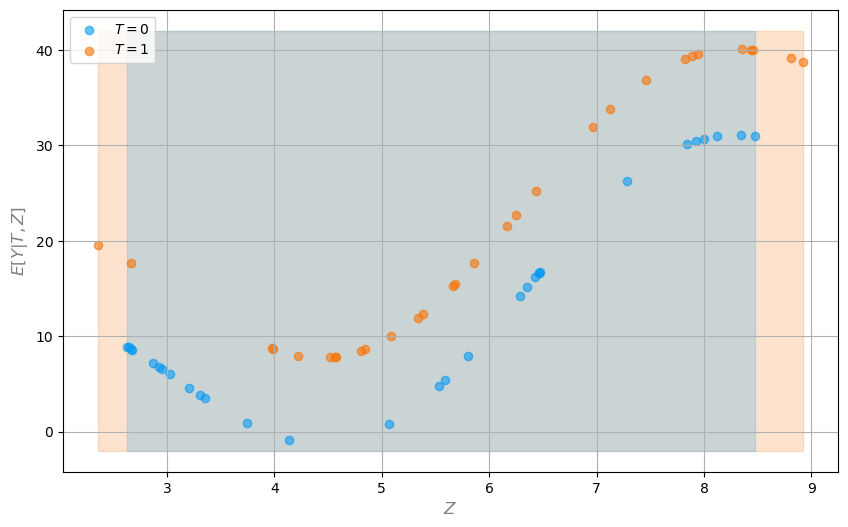

In [37]:
plt.figure(figsize=(10, 6))

plt.fill_betweenx([-2, 42], min(z_t1), max(z_t1), color=COLORS[1], alpha=.2)
plt.fill_betweenx([-2, 42], min(z_t0), max(z_t0), color=COLORS[0], alpha=.2)

plt.scatter(z_t0, y_t0, color=COLORS[0], label='$T=0$', alpha=.6)
plt.scatter(z_t1, y_t1, color=COLORS[1], label='$T=1$', alpha=.6)

plt.xlabel('$Z$', alpha=.5, fontsize=12)
plt.ylabel('$E[Y|T, Z]$', alpha=.5, fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

### Modularity

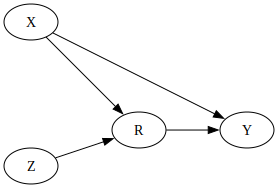

In [38]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Y', 'R', 'Z']
positions = ['1,2!', '4,.5!', '2.5,.5!', '1, 0!']

edges = ['XR', 'ZR', 'RY', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_modularity')

graph

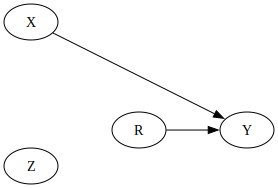

In [39]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Y', 'R', 'Z']
positions = ['1,2!', '4,.5!', '2.5,.5!', '1, 0!']

edges = ['RY', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_modularity_mod')

graph

### Selection Bias: Missing Holes & Abraham Wald

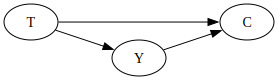

In [40]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['T', 'Y', 'C']
positions = ['0,.5!', '1.5,0!', '3,.5!']

edges = ['TY', 'TC', 'YC']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_selection')

graph

In [41]:
SAMPLE_SIZE = 1000

# A hypothetical SCM
T = np.random.uniform(20, 110, SAMPLE_SIZE)
Y = T + np.random.uniform(0, 40, SAMPLE_SIZE)
C = (T + Y < 100).astype('int')

In [42]:
df = pd.DataFrame(np.stack([T, Y, C]).T, columns=['T', 'Y', 'C'])

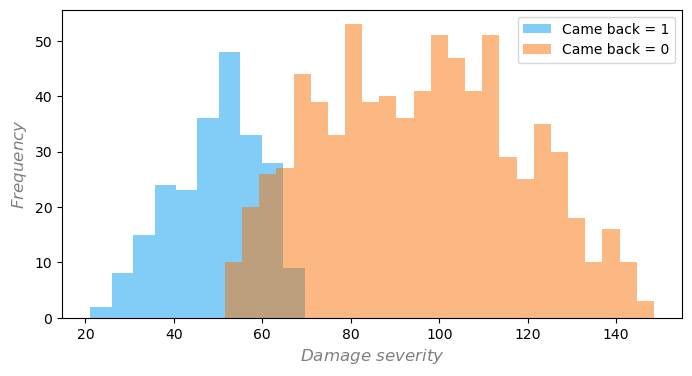

In [43]:
# Compare average damage (biased vs unbiased)
plt.figure(figsize=(8, 4))

plt.hist(df[df['C'] == 1]['Y'], label='Came back = 1', color=COLORS[0], alpha=.5)
plt.hist(df[df['C'] == 0]['Y'], label='Came back = 0', color=COLORS[1], alpha=.5, bins=25)

plt.xlabel('$Damage$ $severity$', alpha=.5, fontsize=12)
plt.ylabel('$Frequency$', alpha=.5, fontsize=12)

plt.legend()
plt.show()

### More Selection Bias

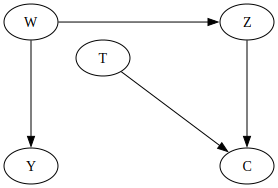

In [44]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['T', 'Y', 'C', 'Z', 'W']
positions = ['1.,1.5!', '0,0!', '3,0!', '3,2!', '0,2!']

edges = ['ZC', 'TC', 'WZ', 'WY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_selection_02')

graph

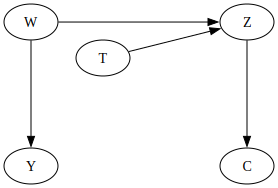

In [45]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['T', 'Y', 'C', 'Z', 'W']
positions = ['1.,1.5!', '0,0!', '3,0!', '3,2!', '0,2!']

edges = ['TZ', 'ZC', 'WZ', 'WY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_selection_03')

graph